# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import MinMaxScaler
sns.set()
warnings.filterwarnings('ignore')

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
### Portfolio Dataset

portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [3]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [4]:
portfolio['reward'].value_counts()

5     3
0     2
2     2
10    2
3     1
Name: reward, dtype: int64

In [5]:
portfolio['offer_type'].value_counts()

discount         4
bogo             4
informational    2
Name: offer_type, dtype: int64

In [6]:
### Profile Dataset

profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [7]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [8]:
profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

<AxesSubplot:xlabel='age', ylabel='Count'>

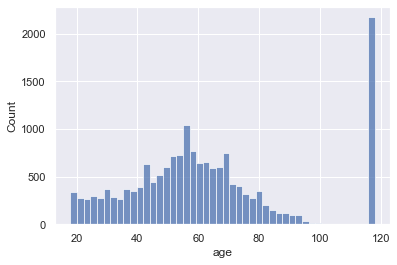

In [9]:
sns.histplot(profile['age'])

<AxesSubplot:xlabel='age', ylabel='Count'>

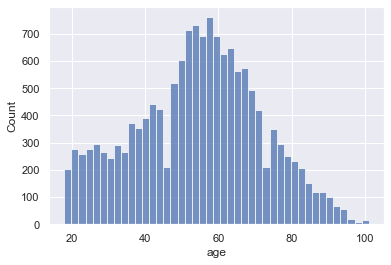

In [10]:
sns.histplot(profile[profile['age'] < 118]['age'])

<AxesSubplot:xlabel='income', ylabel='Count'>

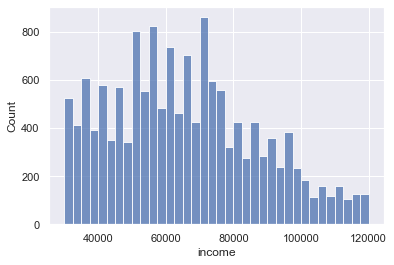

In [11]:
sns.histplot(profile['income'])

In [12]:
### Transcript Dataset

transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [13]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [14]:
transcript['value']

0         {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2         {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3         {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4         {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
                                ...                       
306529                      {'amount': 1.5899999999999999}
306530                                    {'amount': 9.53}
306531                                    {'amount': 3.61}
306532                      {'amount': 3.5300000000000002}
306533                                    {'amount': 4.05}
Name: value, Length: 306534, dtype: object

In [15]:
transcript['person'].value_counts()

94de646f7b6041228ca7dec82adb97d2    51
8dbfa485249f409aa223a2130f40634a    49
d0a80415b84c4df4908b8403b19765e3    48
5e60c6aa3b834e44b822ea43a3efea26    48
79d9d4f86aca4bed9290350fb43817c2    48
                                    ..
fccc9279ba56411f80ffe8ce7e0935cd     2
3045af4e98794a04a5542d3eac939b1f     2
df9fc9a86ca84ef5aedde8925d5838ba     2
e63e42480aae4ede9f07cac49c8c3f78     2
da7a7c0dcfcb41a8acc7864a53cf60fb     1
Name: person, Length: 17000, dtype: int64

In [16]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [17]:
### Data Processing

In [18]:
### Portfolio DP

df_portfolio = portfolio.copy()
df_portfolio = df_portfolio.rename(columns={'id':'id_offer'})
#df_portfolio[['difficulty','duration']] = df_portfolio[['difficulty','reward']].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
df_portfolio['channels'] = df_portfolio['channels'].astype('str').str.replace('[','').str.replace(']','')

oh = pd.get_dummies(df_portfolio['channels'])
df_portfolio = pd.concat([df_portfolio, oh], axis=1)

df_portfolio.offer_type = pd.Categorical(df_portfolio.offer_type)
df_portfolio['offer_type'] = df_portfolio.offer_type.cat.codes

scaler = MinMaxScaler()
df_portfolio[['difficulty','reward']] = scaler.fit_transform(df_portfolio[['difficulty','reward']])


In [19]:
df_portfolio.head()

,reward,channels,difficulty,duration,offer_type,id_offer,"'email', 'mobile', 'social'","'web', 'email'","'web', 'email', 'mobile'","'web', 'email', 'mobile', 'social'"
0,1.0,"'email', 'mobile', 'social'",0.50,7,0,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0,0
1,1.0,"'web', 'email', 'mobile', 'social'",0.50,5,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0,0,1
2,0.0,"'web', 'email', 'mobile'",0.00,4,2,3f207df678b143eea3cee63160fa8bed,0,0,1,0
3,0.5,"'web', 'email', 'mobile'",0.25,7,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,1,0
4,0.5,"'web', 'email'",1.00,10,1,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0


In [20]:
df_portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   reward                              10 non-null     float64
 1   channels                            10 non-null     object 
 2   difficulty                          10 non-null     float64
 3   duration                            10 non-null     int64  
 4   offer_type                          10 non-null     int8   
 5   id_offer                            10 non-null     object 
 6   'email', 'mobile', 'social'         10 non-null     uint8  
 7   'web', 'email'                      10 non-null     uint8  
 8   'web', 'email', 'mobile'            10 non-null     uint8  
 9   'web', 'email', 'mobile', 'social'  10 non-null     uint8  
dtypes: float64(2), int64(1), int8(1), object(2), uint8(4)
memory usage: 578.0+ bytes


In [21]:
### Profile DP

df_profile = profile.copy()

df_profile = df_profile.dropna(axis=0)

df_profile['age'] = df_profile['age'].astype('int')
df_profile['income'] = df_profile['income'].astype('int')

df_profile = df_profile.rename(columns={'id':'id_customer'})

df_profile.gender = pd.Categorical(df_profile.gender)
df_profile['gender'] = df_profile.gender.cat.codes + 1

df_profile['membership_loyality'] = pd.to_datetime(df_profile['became_member_on'], format='%Y%m%d').dt.date
df_profile['membership_loyality'] = df_profile['membership_loyality'].max() - \
                                    pd.to_datetime(df_profile['became_member_on'], format='%Y%m%d').dt.date


df_profile['membership_loyality'] = pd.cut(df_profile['membership_loyality'],4, labels=[1,2,3,4])
df_profile['age_bin'] = pd.cut(df_profile['age'],4, labels=[1,2,3,4])
df_profile['income_bin'] = pd.cut(df_profile['income'],5, labels=[1,2,3,4,5])

df_profile = df_profile.drop(columns=['age','income','became_member_on'])

Age Intervals

1. 18 - 38,75
2. 38.75 - 59.5
3. 59.5 - 80.25
4. 80.25 - 101

Income Intervals

1. 30k - 48k
2. 48k - 66k
3. 66k - 84k
4. 84k - 102k
5. 102k - 120k

Genders

1. F
2. M
3. O

Loyality Intervals

1. 0 - 455 days
2. 455 - 911 days
3. 911 - 1367 days
4. 1367 - 1823 days

In [22]:
df_profile.head()

,gender,id_customer,membership_loyality,age_bin,income_bin
1,1,0610b486422d4921ae7d2bf64640c50b,1,2,5
3,1,78afa995795e4d85b5d9ceeca43f5fef,1,3,4
5,2,e2127556f4f64592b11af22de27a7932,1,3,3
8,2,389bc3fa690240e798340f5a15918d5c,1,3,2
12,2,2eeac8d8feae4a8cad5a6af0499a211d,1,2,2


### Transcript DP

In [23]:
df_transcript = transcript.copy()
df_transcript = df_transcript.rename(columns={'person':'id_customer','offer_id':'id_offer'})


In [24]:
keys = []
for index, row in df_transcript.iterrows():
    for k in row['value']:
        if k in keys:
            continue
        else:
            keys.append(k)
            
keys

['offer id', 'amount', 'offer_id', 'reward']

In [25]:
df_transcript['id_offer'] = ''
df_transcript['amount'] = 0
df_transcript['reward'] = 0

In [26]:
for index, row in df_transcript.iterrows():
    for k in row['value']:
        if k == 'offer_id' or k == 'offer id':
            df_transcript.at[index, 'id_offer'] = row['value'][k]
        if k == 'amount':
            df_transcript.at[index, 'amount'] = row['value'][k]
        if k == 'reward':
            df_transcript.at[index, 'reward'] = row['value'][k]

In [27]:
df_transcript['id_offer'] = df_transcript['id_offer'].apply(lambda x: np.nan if x == '' else x)
df_transcript = df_transcript.drop(columns=['value'])

In [28]:
df_transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id_customer  306534 non-null  object
 1   event        306534 non-null  object
 2   time         306534 non-null  int64 
 3   id_offer     167581 non-null  object
 4   amount       306534 non-null  int64 
 5   reward       306534 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 14.0+ MB


Considering that the focus is about complete cycles and the type 'offer_completed' itself means that a transaction was made, we're going to drop all 'transactions' events.

But if we think better, we can also drop the 'offer received' events, because there are customers that complete offers without knowing about them. So this kind of events may pollute our data.

In [29]:
df_transcript = df_transcript[(df_transcript['event'] != 'transaction')]
df_transcript = df_transcript[(df_transcript['event'] != 'offer received')] 

In [30]:
df_transcript.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91304 entries, 12650 to 306527
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id_customer  91304 non-null  object
 1   event        91304 non-null  object
 2   time         91304 non-null  int64 
 3   id_offer     91304 non-null  object
 4   amount       91304 non-null  int64 
 5   reward       91304 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 4.9+ MB


## Merging

In [31]:
df_final = df_transcript.merge(df_portfolio, how='left', on='id_offer')
df_final = df_final.merge(df_profile, how='left', on='id_customer')

df_final = df_final.dropna(how='any',axis=0)

df_final.id_customer = pd.Categorical(df_final.id_customer)
df_final['id_customer'] = df_final.id_customer.cat.codes + 1

df_final.id_offer = pd.Categorical(df_final.id_offer)
df_final['id_offer'] = df_final.id_offer.cat.codes + 1

In [32]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82304 entries, 0 to 91303
Data columns (total 19 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   id_customer                         82304 non-null  int16   
 1   event                               82304 non-null  object  
 2   time                                82304 non-null  int64   
 3   id_offer                            82304 non-null  int8    
 4   amount                              82304 non-null  int64   
 5   reward_x                            82304 non-null  int64   
 6   reward_y                            82304 non-null  float64 
 7   channels                            82304 non-null  object  
 8   difficulty                          82304 non-null  float64 
 9   duration                            82304 non-null  int64   
 10  offer_type                          82304 non-null  int8    
 11  'email', 'mobile', 'social' 

In [33]:
df_final

,id_customer,event,time,id_offer,amount,reward_x,reward_y,channels,difficulty,duration,offer_type,"'email', 'mobile', 'social'","'web', 'email'","'web', 'email', 'mobile'","'web', 'email', 'mobile', 'social'",gender,membership_loyality,age_bin,income_bin
0,3236,offer viewed,0,9,0,0,0.5,"'web', 'email', 'mobile', 'social'",0.25,5,0,0,0,0,1,2.0,1,3,2
1,12121,offer viewed,0,6,0,0,0.0,"'email', 'mobile', 'social'",0.00,3,2,1,0,0,0,3.0,1,2,2
2,919,offer viewed,0,5,0,0,1.0,"'web', 'email', 'mobile', 'social'",0.50,5,0,0,0,0,1,1.0,2,3,2
3,149,offer viewed,0,8,0,0,1.0,"'email', 'mobile', 'social'",0.50,7,0,1,0,0,0,1.0,2,1,1
4,11053,offer viewed,0,6,0,0,0.0,"'email', 'mobile', 'social'",0.00,3,2,1,0,0,0,2.0,4,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91297,7667,offer viewed,714,6,0,0,0.0,"'email', 'mobile', 'social'",0.00,3,2,1,0,0,0,1.0,1,3,5
91298,9983,offer viewed,714,4,0,0,0.0,"'web', 'email', 'mobile'",0.00,4,2,0,0,1,0,2.0,4,2,3
91301,8204,offer viewed,714,1,0,0,0.5,"'web', 'email'",1.00,10,1,0,1,0,0,1.0,1,3,2
91302,7614,offer completed,714,10,0,2,0.2,"'web', 'email', 'mobile', 'social'",0.50,10,1,0,0,0,1,2.0,1,2,1


In [34]:
### Time for some exploration 2906b810c7d4411798c6938adc9daaa5 

In [35]:
# 1. What's the viewed x completed ratio?
# 2. 
# 3. How is the distribution of the loyality customers?
# 4. How is the distribution of the age between type of offers?
# 5. What is the age of our optimal persona (views and complete?
# 6. And what is the predominant gender?
# 7. And what's our Persona's average income? 
# 8. Do higher rewarded offers have more completions than lower ones?
# 9. Is there a preferable difficult ratio for completing an offer?
# 10. What are the most popular offers for our Persona?

In [36]:
### Q1

<AxesSubplot:xlabel='event', ylabel='count'>

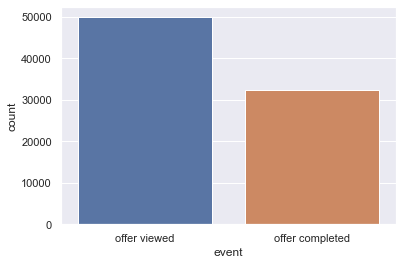

In [37]:
sns.countplot(x="event", data=df_final)

In [38]:
df_final[df_final['event'] == 'offer viewed'].shape[0]

49860

In [39]:
df_final[df_final['event'] == 'offer completed'].shape[0]

32444

In [40]:
df_final[df_final['event'] == 'offer viewed'].shape[0] - df_final[df_final['event'] == 'offer completed'].shape[0]

17416

In [41]:
df_final[df_final['event'] == 'offer completed'].shape[0] / df_final[df_final['event'] == 'offer viewed'].shape[0]

0.6507019655034095

In [42]:
### Q3

<AxesSubplot:xlabel='membership_loyality', ylabel='count'>

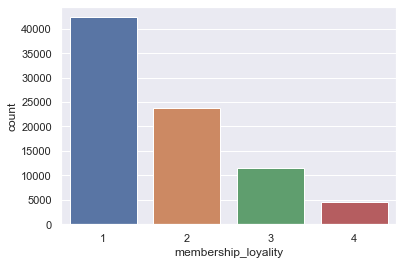

In [43]:
sns.countplot(x="membership_loyality", data=df_final)

Loyality Intervals

1. 0 - 455 days
2. 455 - 911 days
3. 911 - 1367 days
4. 1367 - 1823 days

In [44]:
### Q4

<AxesSubplot:xlabel='age_bin', ylabel='count'>

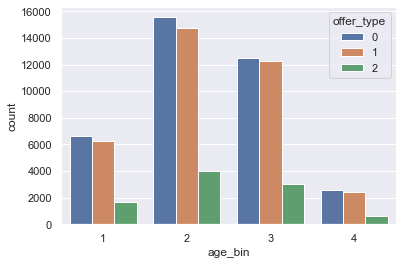

In [45]:
sns.countplot(x="age_bin", hue="offer_type", data=df_final)

Age Intervals

1. 18 - 38,75
2. 38.75 - 59.5
3. 59.5 - 80.25
4. 80.25 - 101

Offers

0. Bogo
1. Discount
2. Informational

<AxesSubplot:xlabel='offer_type', ylabel='count'>

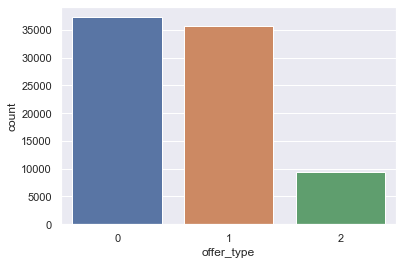

In [46]:
sns.countplot(x="offer_type", data=df_final)

Both BOGO and Discount offers have almost the same rate.
They may have also the same performance

In [47]:
### Q5

In [48]:
df_opt_persona = df_final[df_final['event'] == 'offer completed']

<AxesSubplot:xlabel='age_bin', ylabel='count'>

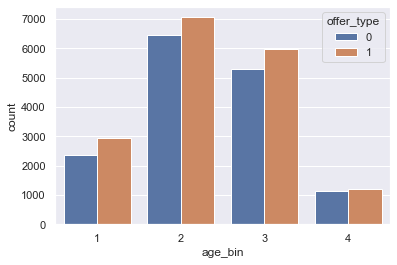

In [49]:
sns.countplot(x="age_bin", hue="offer_type", data=df_opt_persona)

2 and 3 are the best ages based on only completed offers

In [50]:
### Q6

<AxesSubplot:xlabel='gender', ylabel='count'>

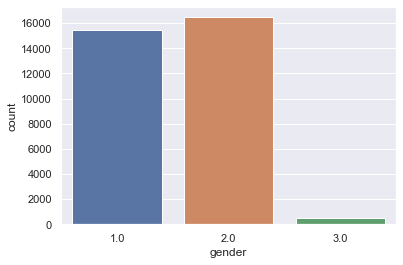

In [51]:
sns.countplot(x="gender", data=df_opt_persona)

Genders

1. F
2. M
3. O

There a slight more men than women in this case (completed offers)

<AxesSubplot:xlabel='gender', ylabel='count'>

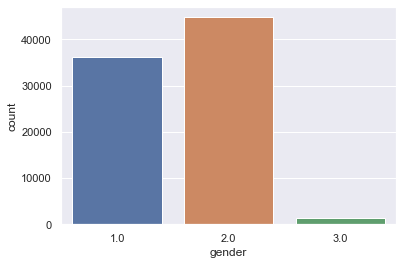

In [52]:
sns.countplot(x="gender", data=df_final)

In [53]:
### Q7

df_opt_persona = df_final[df_final['event'] == 'offer completed']

<AxesSubplot:xlabel='income_bin', ylabel='count'>

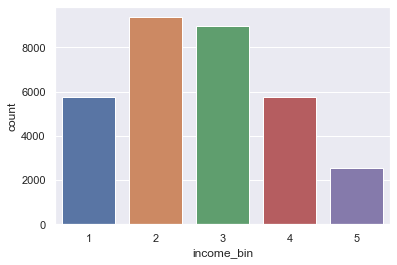

In [54]:
sns.countplot(x="income_bin", data=df_opt_persona)

Income Intervals

1. 30k - 48k
2. 48k - 66k
3. 66k - 84k
4. 84k - 102k
5. 102k - 120k

In [55]:
### Q8

<AxesSubplot:xlabel='reward_x', ylabel='count'>

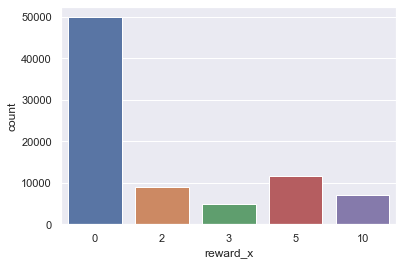

In [56]:
sns.countplot(x="reward_x", data=df_final)

<AxesSubplot:xlabel='reward_y', ylabel='count'>

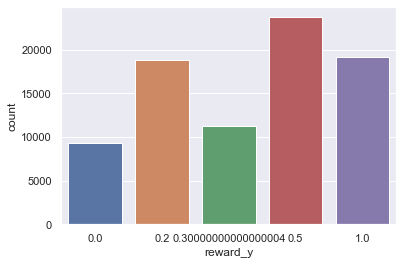

In [57]:
sns.countplot(x="reward_y", data=df_final)

In [58]:
### Q9

<AxesSubplot:xlabel='difficulty', ylabel='count'>

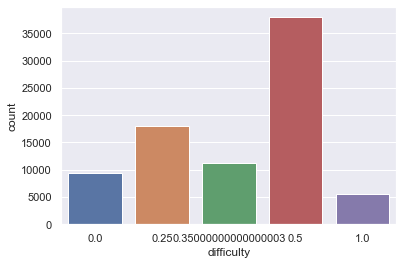

In [59]:
sns.countplot(x="difficulty", data=df_final)

Here we can see that the 0.5 difficulty is the most popular one, so it may worth dive in this feature.

In [60]:
df_dif = df_final[df_final['difficulty'] == 0.5]

In [61]:
df_dif.head()

,id_customer,event,time,id_offer,amount,reward_x,reward_y,channels,difficulty,duration,offer_type,"'email', 'mobile', 'social'","'web', 'email'","'web', 'email', 'mobile'","'web', 'email', 'mobile', 'social'",gender,membership_loyality,age_bin,income_bin
2,919,offer viewed,0,5,0,0,1.0,"'web', 'email', 'mobile', 'social'",0.5,5,0,0,0,0,1,1.0,2,3,2
3,149,offer viewed,0,8,0,0,1.0,"'email', 'mobile', 'social'",0.5,7,0,1,0,0,0,1.0,2,1,1
5,9278,offer viewed,0,3,0,0,0.2,"'web', 'email', 'mobile'",0.5,7,1,0,0,1,0,2.0,3,2,4
6,9278,offer completed,0,3,0,2,0.2,"'web', 'email', 'mobile'",0.5,7,1,0,0,1,0,2.0,3,2,4
12,14316,offer viewed,0,8,0,0,1.0,"'email', 'mobile', 'social'",0.5,7,0,1,0,0,0,1.0,2,3,3


<AxesSubplot:xlabel='gender', ylabel='count'>

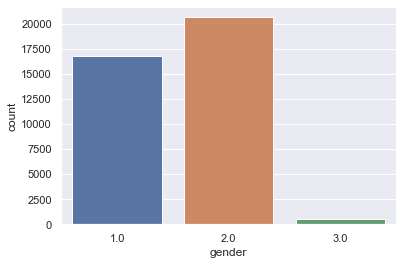

In [62]:
sns.countplot(x="gender", data=df_dif)

In [63]:
### Q10

<AxesSubplot:xlabel='offer_type', ylabel='count'>

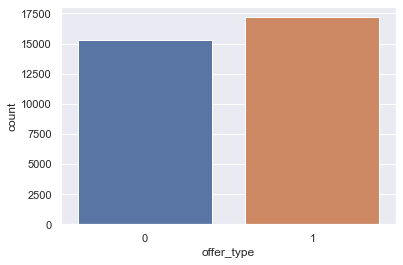

In [64]:
df_opt_persona = df_final[df_final['event'] == 'offer completed']
sns.countplot(x="offer_type", data=df_opt_persona)

## Model

In [65]:
df_final.head()

,id_customer,event,time,id_offer,amount,reward_x,reward_y,channels,difficulty,duration,offer_type,"'email', 'mobile', 'social'","'web', 'email'","'web', 'email', 'mobile'","'web', 'email', 'mobile', 'social'",gender,membership_loyality,age_bin,income_bin
0,3236,offer viewed,0,9,0,0,0.5,"'web', 'email', 'mobile', 'social'",0.25,5,0,0,0,0,1,2.0,1,3,2
1,12121,offer viewed,0,6,0,0,0.0,"'email', 'mobile', 'social'",0.00,3,2,1,0,0,0,3.0,1,2,2
2,919,offer viewed,0,5,0,0,1.0,"'web', 'email', 'mobile', 'social'",0.50,5,0,0,0,0,1,1.0,2,3,2
3,149,offer viewed,0,8,0,0,1.0,"'email', 'mobile', 'social'",0.50,7,0,1,0,0,0,1.0,2,1,1
4,11053,offer viewed,0,6,0,0,0.0,"'email', 'mobile', 'social'",0.00,3,2,1,0,0,0,2.0,4,2,2


In [66]:
events = df_final['event'].astype('category').cat.categories.tolist()
map_event = {'event' : {k: v for k,v in zip(events,list(range(1,len(events)+1)))}}
df_final.replace(map_event, inplace=True)

In [67]:
df_final.rename(columns ={'reward_x':'reward'}, inplace = True)

In [68]:
X = df_final[['time','id_offer','amount','reward','difficulty','duration','offer_type','gender','age_bin','income_bin', 'membership_loyality']]
Y = df_final['event']

In [69]:
scaler = MinMaxScaler()
features = ['time', 'amount', 'reward', 'duration']
X_scaled = X.copy()
X_scaled[features] = scaler.fit_transform(X_scaled[features])
X_scaled.head()

,time,id_offer,amount,reward,difficulty,duration,offer_type,gender,age_bin,income_bin,membership_loyality
0,0.0,9,0.0,0.0,0.25,0.285714,0,2.0,3,2,1
1,0.0,6,0.0,0.0,0.00,0.000000,2,3.0,2,2,1
2,0.0,5,0.0,0.0,0.50,0.285714,0,1.0,3,2,2
3,0.0,8,0.0,0.0,0.50,0.571429,0,1.0,1,1,2
4,0.0,6,0.0,0.0,0.00,0.000000,2,2.0,2,2,4


In [70]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

In [71]:
from sklearn.metrics import precision_recall_fscore_support

def predict_score(model):
    y_pred = model.predict(X_test)
    
    # Calculate the absolute errors
    errors = abs(y_pred - y_test)
    
    # Calculate mean absolute percentage error
    mean_APE = 100 * (errors / y_test)
    accuracy = 100 - np.mean(mean_APE)
    
    return round(accuracy, 3)

In [72]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()

dt.fit(X_train, y_train)
print(f'Accuracy of Decision Tree classifier on training set: {round(dt.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {predict_score(dt)}%')

Accuracy of Decision Tree classifier on training set: 100.0%.
Prediction Accuracy: 100.0%


In [ ]:
from sklearn.svm import SVC

svm = SVC(gamma = 'auto')

svm.fit(X_train, y_train)
print(f'Accuracy of SVM classifier on training set: {round(svm.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {predict_score(svm)}%')

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 100, random_state = 42)

rf.fit(X_train, y_train)
print(f'Accuracy of SVM classifier on training set: {round(rf.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {predict_score(rf)}%')

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

knn.fit(X_train, y_train)
print(f'Accuracy of K-NN classifier on training set: {round(knn.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {predict_score(knn)}%')

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

xgb = GradientBoostingClassifier()

xgb.fit(X_train, y_train)
print(f'Accuracy of XGB classifier on training set: {round(xgb.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {predict_score(xgb)}%')